In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision
import numpy as np
from pathlib import Path 

from pytorch_fid.inception import InceptionV3

from maxent_gan.utils.general_utils import IgnoreLabelDataset
from maxent_gan.utils.metrics.compute_fid_tf import _handle_path, get_activation_statistics

2022-07-07 15:59:56.974400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
batch_size = 100
dims = 2048

device = torch.device(1)

In [4]:
# block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]

# model = InceptionV3().to(device)
# model.eval()
# print()

In [5]:
#dataset_name = 'celeba'
dataset_name = 'cifar10'
#dataset_name = 'stacked_mnist'

In [28]:
dataset = torchvision.datasets.CIFAR10('../data/cifar10', train=True, transform=torchvision.transforms.ToTensor())
dataset = IgnoreLabelDataset(dataset)

# from maxent_gan.datasets.utils import get_dataset

# # dataset = get_dataset(dataset_name, mean=(0,0,0), std=(1,1,1))
# dataset = get_dataset(dataset_name, mean=(0,0,0), std=(1,1,1))
# dataset = dataset['dataset']

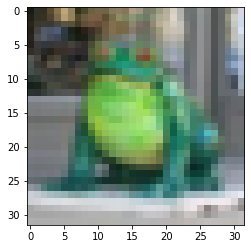

In [29]:
from matplotlib import pyplot as plt

plt.imshow(dataset[19].numpy().transpose(1,2,0))

In [30]:
dataset = torch.stack([batch for batch in dataset], 0).numpy()

In [31]:
dataset.shape

(50000, 3, 32, 32)

In [32]:
# np.save(f'../data/{dataset_name}/np_data.npy', dataset)
np.save(f'../data/{dataset_name}/np_data_cp.npy', dataset)

In [33]:
m, s = get_activation_statistics(f'../data/{dataset_name}/np_data_cp.npy', inception_path="../thirdparty/TTUR/inception_model",)

2022-07-07 16:22:53.453823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:22:53.454029: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-07-07 16:22:53.454108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-07 16:22:53.454264: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.582GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMem

KeyboardInterrupt: 

In [20]:
np.savez(Path(f'../stats/fid_stats_{dataset_name}.npz'), mu=m, sigma=s)

In [ ]:
m

array([0.10106104, 0.24368689, 0.29902793, ..., 0.5182205 , 0.38939511,
       0.65748564])

In [16]:
stats = np.load('../stats/cifar10/cifar10.train.npz')
real_mu, real_sigma = stats["mu"], stats["sigma"]

In [17]:
real_mu

array([0.09976815, 0.24318894, 0.29826408, ..., 0.50716553, 0.39214521,
       0.64979453])

In [35]:
np.load(Path(f'../stats/cifar10/fid_stats_{dataset_name}.npz'))['mu']

array([0.09976813, 0.24318884, 0.2982641 , ..., 0.50716566, 0.39214507,
       0.64979509])

In [5]:
from maxent_gan.models.utils import load_gan
from maxent_gan.utils.general_utils import DotConfig
import yaml
from yaml import Loader


gan_config = '../configs/gan_configs/cifar-10-snresnet.yml' #dcgan.yml'

gan_config = DotConfig(
    yaml.load(Path(gan_config).open("r"), Loader)
)
gen, _ = load_gan(gan_config, device)
# gen.eval()
pass

In [6]:
stats = np.load(Path('../stats/fid_stats_cifar10.npz'))
real_mu, real_sigma = stats['mu'], stats['sigma']

In [15]:
gen.prior

MultivariateNormal(loc: torch.Size([128]), covariance_matrix: torch.Size([128, 128]))

In [7]:
from tqdm import  trange

fids = []
ns = np.array([50000]) #100, 250, 500, 1000, 5000])
batch_size = 1000
for n in ns:
    imgs = []
    for _ in trange(n // batch_size):
        with torch.no_grad():
            # z = torch.rand(batch_size, gen.z_dim).to(device)*2 - 1
            z = torch.randn(batch_size, gen.z_dim).to(device)
            imgs_ = gen(z).detach().cpu()
            imgs_ = gen.inverse_transform(imgs_).detach().cpu()
        imgs.append(imgs_)
    imgs = torch.cat(imgs, 0)

    dataset = torch.utils.data.TensorDataset(imgs.detach().cpu())
    dataset = IgnoreLabelDataset(dataset)
    mu_, sigma_, _ = get_activation_statistics(dataset, model, dims=2048, batch_size=200, num_workers=1, device=device, verbose=True)
    fid = calculate_frechet_distance(mu_, sigma_, real_mu, real_sigma)
    fids.append(fid)

100%|██████████| 250/250 [01:45<00:00,  2.36it/s]


In [8]:
real_mu

array([0.09976813, 0.24318884, 0.2982641 , ..., 0.50716566, 0.39214507,
       0.64979509])

In [9]:
mu_

array([0.10315059, 0.24553338, 0.31235492, ..., 0.54658492, 0.39007485,
       0.67445933])

In [10]:
fids

[15.757999934546092]

In [12]:
imgs[0].shape

torch.Size([3, 32, 32])

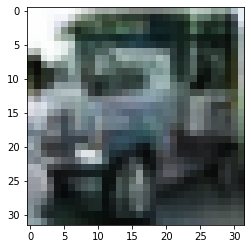

In [14]:
from matplotlib import pyplot as plt

plt.imshow(imgs[56].detach().cpu().numpy().transpose(1, 2, 0))

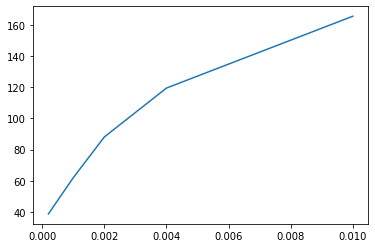

In [15]:
from matplotlib import pyplot as plt

plt.plot(1./ns, fids)
plt.show()

In [16]:
1./ns

array([0.01  , 0.004 , 0.002 , 0.001 , 0.0002])

In [4]:
torchvision.__version__

'0.11.1+cu102'

In [17]:
model = torchvision.models.efficientnet_b3(pretrained=True).to(device)
model.eval()
print()

In [18]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation['avg_pool'] = output.detach()
    return hook
model.avgpool.register_forward_hook(get_activation('avgpool'))

def wrapped_model(x):
    model(x)
    return [activation['avg_pool']]

In [22]:
activation['avg_pool'].shape

torch.Size([100, 1536, 1, 1])

In [19]:
dataset = torchvision.datasets.CIFAR10('../data/cifar10', train=True, transform=torchvision.transforms.ToTensor())
dataset = IgnoreLabelDataset(dataset)

In [23]:
mu, sigma, _ = get_activation_statistics(dataset, wrapped_model, dims=1536, batch_size=100, num_workers=4, device=device)

In [24]:
np.savez(Path('../stats/efficientnet_b3_stats_cifar10.npz'), mu=mu, sigma=sigma)